In [3]:
import os
import torch
import numpy as np
import pandas as pd
import kagglehub
from torchvision import datasets, transforms, models
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

device =  torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {device}")

/Users/academic-city-university/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


In [4]:
path = kagglehub.dataset_download("pacificrm/skindiseasedataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/academic-city-university/.cache/kagglehub/datasets/pacificrm/skindiseasedataset/versions/6


In [5]:
main_dir = os.path.join(path, "SkinDisease","SkinDisease")
train_dir = os.path.join(main_dir, "train")
test_dir = os.path.join(main_dir, "test")
print("Main Directory:", main_dir)

Main Directory: /Users/academic-city-university/.cache/kagglehub/datasets/pacificrm/skindiseasedataset/versions/6/SkinDisease/SkinDisease


In [6]:
image_paths=[]
image_labels=[]
class_dir = os.path.join(main_dir, "train")
class_names = os.listdir(class_dir)
num_classes = len(class_names)

In [7]:
for img_file in os.listdir(class_dir):
    img_path = os.path.join(class_dir, img_file)
    if os.path.isdir(img_path):
        for img in os.listdir(img_path):
            image_paths.append(os.path.join(img_path, img))
            image_labels.append(img_file)
print(f"Total images: {len(image_paths)}")
print(f"Total labels: {len(image_labels)}")

Total images: 13898
Total labels: 13898


In [8]:
df = pd.DataFrame({
    'image_path': image_paths,
    'label': image_labels
})

In [9]:
df

,image_path,label
0,/Users/academic-city-university/.cache/kaggleh...,Tinea
1,/Users/academic-city-university/.cache/kaggleh...,Tinea
2,/Users/academic-city-university/.cache/kaggleh...,Tinea
3,/Users/academic-city-university/.cache/kaggleh...,Tinea
4,/Users/academic-city-university/.cache/kaggleh...,Tinea
...,...,...
13893,/Users/academic-city-university/.cache/kaggleh...,Actinic_Keratosis
13894,/Users/academic-city-university/.cache/kaggleh...,Actinic_Keratosis
13895,/Users/academic-city-university/.cache/kaggleh...,Actinic_Keratosis
13896,/Users/academic-city-university/.cache/kaggleh...,Actinic_Keratosis


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13898 entries, 0 to 13897
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  13898 non-null  object
 1   label       13898 non-null  object
dtypes: object(2)
memory usage: 217.3+ KB


In [11]:
IMAGE_SIZE = 384
BATCH_SIZE = 32
EPOCHS = 25
LR = 0.001

In [12]:
# CutMix(Domain AMP), Test synthetic augmentation
def transfrom_train():
    return transforms.Compose([
        transforms.RandomResizedCrop(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def transfrom_test():
    return transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [13]:
train_dataset = datasets.ImageFolder(train_dir, transform=transfrom_train())
test_dataset = datasets.ImageFolder(test_dir, transform=transfrom_test())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

Class names: ['Acne', 'Actinic_Keratosis', 'Benign_tumors', 'Bullous', 'Candidiasis', 'DrugEruption', 'Eczema', 'Infestations_Bites', 'Lichen', 'Lupus', 'Moles', 'Psoriasis', 'Rosacea', 'Seborrh_Keratoses', 'SkinCancer', 'Sun_Sunlight_Damage', 'Tinea', 'Unknown_Normal', 'Vascular_Tumors', 'Vasculitis', 'Vitiligo', 'Warts']
Number of classes: 22


In [15]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print(f"Number of classes in train dataset: {len(train_dataset.classes)}")
print(f"Number of classes in test dataset: {len(test_dataset.classes)}")

Number of training samples: 13898
Number of testing samples: 1546
Number of classes in train dataset: 22
Number of classes in test dataset: 22


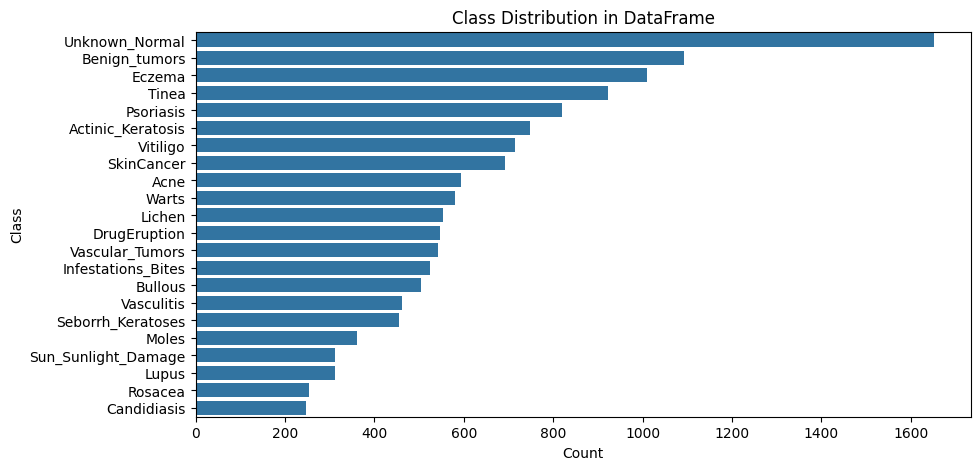

In [16]:
# Check class distribution
plt.figure(figsize=(10,5))
sns.countplot(y='label', data=df, order=df['label'].value_counts().index)
plt.title('Class Distribution in DataFrame') 
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

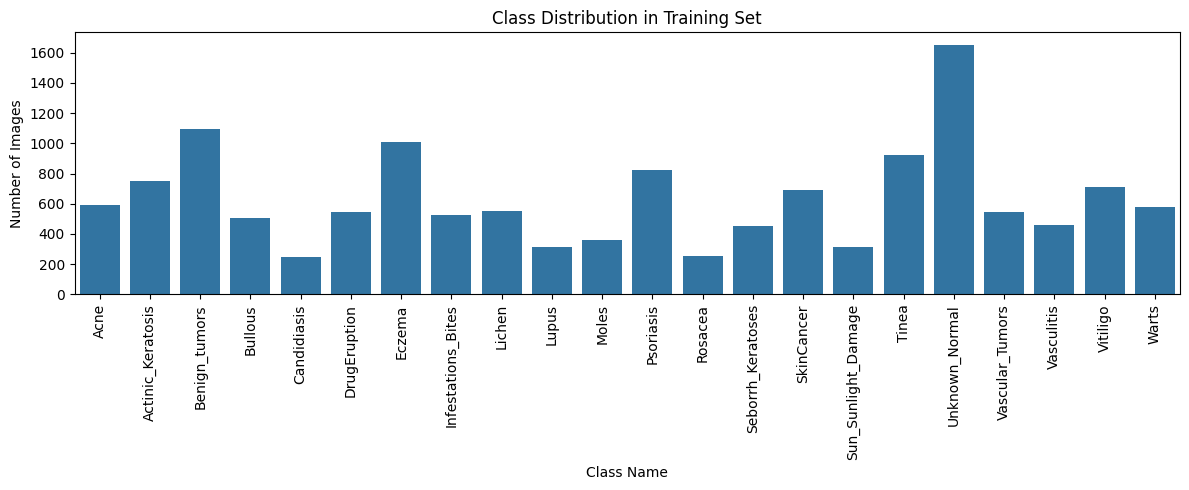

In [17]:
from collections import Counter

# Class distribution bar chart
label_counts = Counter(train_dataset.targets)
plt.figure(figsize=(12, 5))
sns.barplot(x=[class_names[i] for i in label_counts.keys()], y=list(label_counts.values()))
plt.xticks(rotation=90)
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Images")
plt.xlabel("Class Name")
plt.tight_layout()
plt.show()

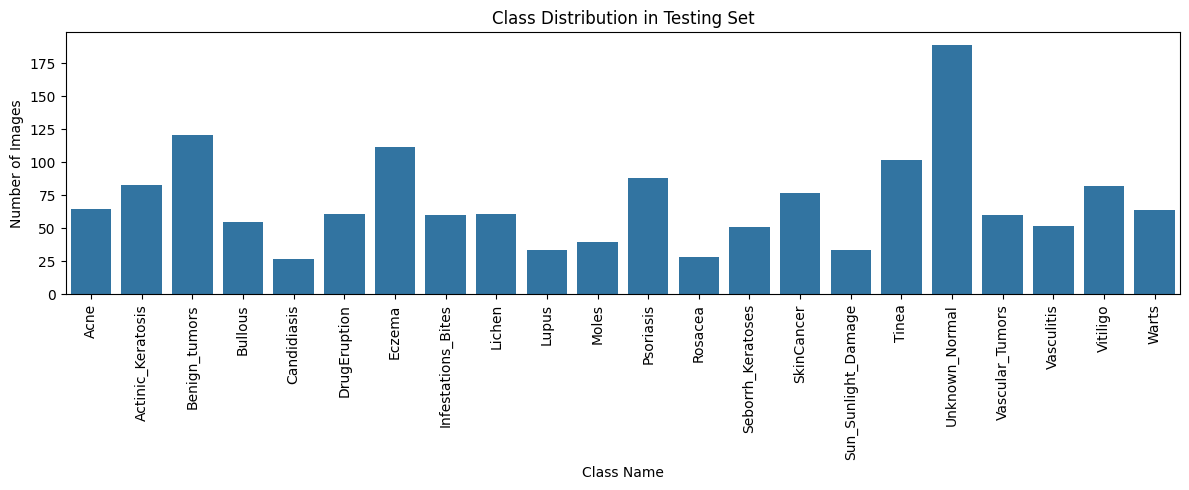

In [18]:
# Check class distribution in testing dataset
test_label_counts = Counter(test_dataset.targets)
plt.figure(figsize=(12, 5))
sns.barplot(x=[class_names[i] for i in test_label_counts.keys()], y=list(test_label_counts.values()))
plt.xticks(rotation=90)
plt.title("Class Distribution in Testing Set")
plt.ylabel("Number of Images")
plt.xlabel("Class Name")
plt.tight_layout()
plt.show()

In [19]:
#Data Exploration
import random
def plot_samples(dataset, class_names, num_samples=5):#Pick random samples
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        random_idx = random.randint(0, len(dataset)-1)
        img, label = dataset[random_idx]
        img = img.numpy().transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(img)
        plt.title(class_names[label])
        plt.axis("off")
    plt.show()

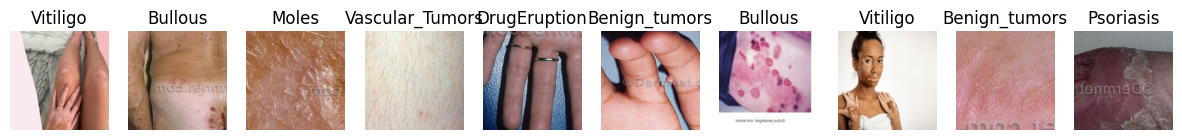

In [20]:
plot_samples(train_dataset, class_names, num_samples = 10)

In [21]:
labels = train_dataset.targets
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

Class weights: tensor([1.0653, 0.8446, 0.5780, 1.2534, 2.5473, 1.1549, 0.6255, 1.2056, 1.1424,
        2.0313, 1.7499, 0.7704, 2.4871, 1.3884, 0.9116, 2.0248, 0.6844, 0.3826,
        1.1634, 1.3703, 0.8848, 1.0892], device='mps:0')


In [22]:
# # Correct way to load pre-trained models in newer PyTorch versions
# model1 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
# model2 = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
# model3 = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)

# models = {model1: 'resnet50', model2: 'efficientnet_b3', model3: 'vit_b_16'}
# for model in models:
#     model.to(device)
#     print(f"{models[model]} loaded successfully!")

In [23]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [24]:
# import pytorch_warmup as warmup

# optimizers = {
#     model1: optim.AdamW(model1.parameters(), lr=LR),
#     model2: optim.AdamW(model2.parameters(), lr=LR),
#     model3: optim.AdamW(model3.parameters(), lr=LR)
# }

# schedulers = {
#     model1: optim.lr_scheduler.CosineAnnealingLR(optimizers[model1], T_max=EPOCHS),
#     model2: optim.lr_scheduler.CosineAnnealingLR(optimizers[model2], T_max=EPOCHS),
#     model3: optim.lr_scheduler.CosineAnnealingLR(optimizers[model3], T_max=EPOCHS)
# }
# schedulers = {
#     model1: optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizers[model1], T_0=5, T_mult=2),
#     model2: optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizers[model2], T_0=5, T_mult=2),
#     model3: optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizers[model3], T_0=5, T_mult=2)
# }
# warmup_schedulers = {
#     model1: warmup.UntunedExponentialWarmup(optimizers[model1]),
#     model2: warmup.UntunedExponentialWarmup(optimizers[model2]),
#     model3: warmup.UntunedExponentialWarmup(optimizers[model3])
# }

In [25]:
# Split train dataset into training and validation sets
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset
train_indices, val_indices = train_test_split(
    np.arange(len(train_dataset)),
    test_size=0.2,
    stratify=train_dataset.targets,
    random_state=42
)
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Number of training samples: {len(train_subset)}")
print(f"Number of validation samples: {len(val_subset)}")


Number of training samples: 11118
Number of validation samples: 2780


In [26]:
def create_model(base_model, num_classes):
    # Get the number of classes in your dataset
    if base_model == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
    elif base_model == "efficientnet_b3":
        model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif base_model == "vit_b_16":
        model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    else:
        raise ValueError(f"Unsupported model type: {base_model}")
    
    return model



In [27]:
model1 = create_model("resnet50", num_classes).to(device)
model2 = create_model("efficientnet_b3", num_classes).to(device)
model3 = create_model("vit_b_16", num_classes).to(device)

models =  {model1: 'resnet50', model2: 'efficientnet_b3', model3: 'vit_b_16'}

In [28]:

# Create optimizer, scheduler, etc.
optimizers = {
    model1: torch.optim.Adam(model1.parameters(), lr=0.001),
    model2: torch.optim.Adam(model2.parameters(), lr=0.001),
    model3: torch.optim.Adam(model3.parameters(), lr=0.001)
}

# Create the scheduler without weight tensors or with matching weight tensors
schedulers = {
    model1: torch.optim.lr_scheduler.CosineAnnealingLR(optimizers[model1], T_max=10),
    model2: torch.optim.lr_scheduler.CosineAnnealingLR(optimizers[model2], T_max=10),
    model3: torch.optim.lr_scheduler.CosineAnnealingLR(optimizers[model3], T_max=10)
}

# Example warmup scheduler (if needed)
class WarmupScheduler:
    def __init__(self, optimizer, warmup_steps):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.current_step = 0
        
    def step(self):
        self.current_step += 1
        
    def get_lr(self):
        return [base_lr * min(1.0, self.current_step / self.warmup_steps) 
                for base_lr in self.base_lrs]

warmup_schedulers = {
    model1: WarmupScheduler(optimizers[model1], warmup_steps=5),
    model2: WarmupScheduler(optimizers[model2], warmup_steps=5),
    model3: WarmupScheduler(optimizers[model3], warmup_steps=5)
}

In [29]:
# Training loop
def train_model(model, optimizer, scheduler, warmup_scheduler, num_epochs=EPOCHS):
    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if warmup_scheduler is not None:
                warmup_scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= total
        val_acc = correct / total

        if scheduler is not None:
            scheduler.step()

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"best_model_{models[model]}.pth")
            print(f"Best model saved with accuracy: {best_val_acc:.4f}")

    return history

**Starting with the ResNet50 model** 

In [31]:
# train_model(model3, optimizers[model3], schedulers[model3], warmup_schedulers[model3], num_epochs=EPOCHS)

In [32]:
# Evaluation function

In [34]:
# Model Fusion Techniques: Simple Averaging and Majority Voting

def fuse_predictions(models, dataloader, device, fusion_method='average'):
    all_outputs = []
    all_labels = []
    for model in models:
        model.eval()
        outputs = []
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                out = model(inputs)
                outputs.append(out.cpu())
                if len(all_labels) == 0:
                    all_labels.extend(labels.numpy())
        all_outputs.append(torch.cat(outputs, dim=0))
    
    # Stack outputs: shape [num_models, num_samples, num_classes]
    stacked_outputs = torch.stack(all_outputs)
    
    if fusion_method == 'average':
        # Average the softmax probabilities
        probs = torch.softmax(stacked_outputs, dim=2)
        avg_probs = probs.mean(dim=0)
        fused_preds = avg_probs.argmax(dim=1).numpy()
    elif fusion_method == 'majority':
        # Majority voting on predicted classes
        preds = stacked_outputs.argmax(dim=2)  # [num_models, num_samples]
        fused_preds = []
        for i in range(preds.shape[1]):
            votes = preds[:, i].numpy()
            fused_preds.append(np.bincount(votes).argmax())
        fused_preds = np.array(fused_preds)
    else:
        raise ValueError("fusion_method must be 'average' or 'majority'")
    
    return fused_preds, np.array(all_labels)

# Example usage:
fused_preds, true_labels = fuse_predictions([model1, model2], val_loader, device, fusion_method='average')